## Coursera Applied Data Science Capstone

### Business Problem

For this capstone I would like to consider the case of a security systems company looking to market products or services in Raleigh, North Carolina. In order to craft appealing sales propositions, such a company would benefit from first knowing which areas of the city tend to have higher crime rates, and then what kinds of venues besides home residences are in the vicinity of higher crime areas. The company would then be in a better position to determine what products or services to offer, and locations where such offerings would likely be in higher demand.

### Data

This analysis will require two data sources: 1) data on crime in Raleigh, NC and 2) data on venues in the vicinity of clusters of crime.

Crime data is available via Raleigh's [open data] website. The specific data resource I will use is the [Raleigh Police Incidents (NIBRS)], accessed January 20, 2019. This set contains 234,352 police incidents from June 1, 2014 through January 20, 2019. Raleigh implemented the FBI's National Incident Based Reporting System (NIBRS) in June 2014. NIBRS now collects each offense, victim, offender, property, and arrestee information on 52 unique offenses and up to 10 offenses per incident.

The Raleigh data shows police incidences were reported in 33 categories.
In addressing the proposed business problem, my analysis will include the police incidents for the categories below, for which have corresponding latitude and longitude values reported.

ARSON, ASSAULT, BURGLARY/COMMERCIAL, BURGLARY/RESIDENTIAL, DISORDERLY CONDUCT, EXTORTION, HUMANE, KIDNAPPNIG, LARCENY, LARCENY FROM MV, MURDER, MV THEFT, ROBBERY, STOLEN PROPERTY, VANDALISM

For venue information I will utilize Foursquare to obtain data. This will include the top venue types near each cluster of crime incidences, along with address. By viewing these results the security company will be able to better decide what types of services and products to offer, and if there are opportunities to customize advertising.


[open data]: http://data-ral.opendata.arcgis.com/
[Raleigh Police Incidents (NIBRS)]: http://data-ral.opendata.arcgis.com/datasets/raleigh-police-incidents-nibrs/data

### Importing and Cleaning Raleigh Crime Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium


In [2]:
data = pd.read_csv("/Users/brian/Documents/Coursera/Raleigh_Police_Incidents_NIBRS 1.20.19.csv")

In [3]:
# Examine columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234352 entries, 0 to 234351
Data columns (total 21 columns):
OBJECTID                  234352 non-null int64
GlobalID                  234352 non-null object
case_number               177749 non-null object
crime_category            234352 non-null object
crime_code                234352 non-null object
crime_description         234352 non-null object
crime_type                137935 non-null object
reported_block_address    177565 non-null object
city_of_incident          177093 non-null object
city                      234350 non-null object
district                  234021 non-null object
reported_date             234352 non-null object
reported_year             234352 non-null int64
reported_month            234352 non-null int64
reported_day              234352 non-null int64
reported_hour             234352 non-null int64
reported_dayofwk          234352 non-null object
latitude                  177093 non-null float64
longitude  

In [4]:
# Look at total records by crime category. Also checking to see if lat/long present.
data.groupby('crime_category').count()[['OBJECTID', 'latitude', 'longitude']]

,OBJECTID,latitude,longitude
crime_category,,,
ALL OTHER OFFENSES,11126,10545,10545
ARSON,238,237,237
ASSAULT,28057,26767,26767
BRIBERY,4,4,4
BURGLARY/COMMERCIAL,2089,2087,2087
BURGLARY/RESIDENTIAL,8192,8184,8184
DISORDERLY CONDUCT,2235,2228,2228
DRUG VIOLATIONS,9432,9379,9379
DRUGS,17789,17669,17669


In [5]:
# Narrowing to crime categories that can be addressed via security systems and monitoring
crime_category_list = ['ARSON', 'ASSAULT', 'BURGLARY/COMMERCIAL', 'BURGLARY/RESIDENTIAL', 'DISORDERLY CONDUCT', 'EXTORTION', 'HUMANE', 'KIDNAPPING', 'LARCENY', 'LARCENY FROM MV', 'MURDER', 'MV THEFT', 'ROBBERY', 'STOLEN PROPERTY', 'VANDALISM']
crime_data = data.loc[data['crime_category'].isin(crime_category_list)]

In [6]:
crime_data.groupby('crime_category').count()[['OBJECTID', 'latitude', 'longitude']]

,OBJECTID,latitude,longitude
crime_category,,,
ARSON,238,237,237
ASSAULT,28057,26767,26767
BURGLARY/COMMERCIAL,2089,2087,2087
BURGLARY/RESIDENTIAL,8192,8184,8184
DISORDERLY CONDUCT,2235,2228,2228
EXTORTION,165,164,164
HUMANE,5278,5255,5255
KIDNAPPING,182,181,181
LARCENY,24363,24320,24320


#### Remove incidences where no lat/long is given
Dropping incidences with missing location data is reasonable given the goal (targeted products and advertising), and the data - where many of these incidences are not crimes suitable for security monitoring (for example child abuse).

In [7]:
crime_data = crime_data[crime_data.latitude.notnull()]

In [8]:
crime_data.groupby('crime_category').count()[['OBJECTID', 'latitude', 'longitude']]

,OBJECTID,latitude,longitude
crime_category,,,
ARSON,237,237,237
ASSAULT,26767,26767,26767
BURGLARY/COMMERCIAL,2087,2087,2087
BURGLARY/RESIDENTIAL,8184,8184,8184
DISORDERLY CONDUCT,2228,2228,2228
EXTORTION,164,164,164
HUMANE,5255,5255,5255
KIDNAPPING,181,181,181
LARCENY,24320,24320,24320


In [9]:
crime_data.reset_index(drop=True, inplace=True)

In [10]:
crime_data.head(50)

,OBJECTID,GlobalID,case_number,crime_category,crime_code,crime_description,crime_type,reported_block_address,city_of_incident,city,...,reported_date,reported_year,reported_month,reported_day,reported_hour,reported_dayofwk,latitude,longitude,agency,updated_date
0,25636,babbc5d0-91f5-46a4-b2c0-edb0e2194ab3,P18004894,ASSAULT,25E,Assault/Simple,CRIMES AGAINST PERSONS,5400 BLOCK NORTH HILLS DR,RALEIGH,RALEIGH,...,2018-01-28T08:18:00.000Z,2018,1,28,3,Sunday,35.851238,-78.659948,RPD,2018-10-24T16:53:12.000Z
1,37323,918a96c9-5b00-44bf-b635-ca5199f36b1d,P18006235,ASSAULT,25E,Assault/Simple,CRIMES AGAINST PERSONS,5500 BLOCK CHATT CT,RALEIGH,RALEIGH,...,2018-02-04T03:16:00.000Z,2018,2,3,22,Saturday,35.889033,-78.550110,RPD,2018-10-24T17:02:01.000Z
2,46792,73c9805a-1e59-4323-b5d4-785868f4ee14,P18011080,VANDALISM,80B,All Other/Damage to Property (minor),NaN,6100 BLOCK RIVER LANDINGS DR,RALEIGH,RALEIGH,...,2018-03-01T17:29:00.000Z,2018,3,1,12,Thursday,35.845355,-78.536339,RPD,2018-10-24T17:37:14.000Z
3,57362,107403f8-91a7-42f0-ae24-70e5240ce932,P17008917,LARCENY FROM MV,35F,Larceny/Theft from Motor Vehicle,CRIMES AGAINST PROPERTY,SHADY GROVE CIR & FOREST OAKS DR,RALEIGH,RALEIGH,...,2017-02-17T13:16:00.000Z,2017,2,17,8,Friday,35.858547,-78.602152,RPD,2018-03-19T18:48:19.000Z
4,57363,489530e6-51d6-41e0-9168-c78b917e23fa,P15036620,LARCENY,35D,Larceny/Theft from Building,CRIMES AGAINST PROPERTY,6200 BLOCK GLENWOOD AV,RALEIGH,RALEIGH,...,2015-07-07T13:39:00.000Z,2015,7,7,9,Tuesday,35.856762,-78.703562,RPD,2018-03-21T19:49:08.000Z
5,57369,d015c9ed-9f69-4b6d-93cc-be01b55c0863,P16032494,ASSAULT,25E,Assault/Simple,CRIMES AGAINST PERSONS,9000 BLOCK STONEY RUN DR,RALEIGH,RALEIGH,...,2016-06-13T09:40:00.000Z,2016,6,13,5,Monday,35.905420,-78.661989,RPD,2018-03-27T13:18:25.000Z
6,57371,06ee9f6b-b4ff-4810-8b5d-80bc6d8980ab,P16021245,MV THEFT,40A,Motor Vehicle Theft,CRIMES AGAINST PROPERTY,4800 BLOCK HARBOUR TOWNE DR,RALEIGH,RALEIGH,...,2016-04-20T02:20:00.000Z,2016,4,19,22,Tuesday,35.804000,-78.554695,RPD,2018-03-26T17:56:22.000Z
7,57380,0720e04d-9423-4ba9-99e1-2922d635d40b,P14072097,LARCENY FROM MV,35F,Larceny/Theft from Motor Vehicle,CRIMES AGAINST PROPERTY,3000 BLOCK M E VALENTINE DR,RALEIGH,RALEIGH,...,2014-06-05T14:37:00.000Z,2014,6,5,10,Thursday,35.788327,-78.676599,RPD,2018-03-08T17:37:14.000Z
8,57390,e59cc3b5-52ca-4ca8-a596-6009a2896e63,P17064486,ASSAULT,25E,Assault/Simple,CRIMES AGAINST PERSONS,2500 BLOCK BLACKWOLF RUN LN,RALEIGH,RALEIGH,...,2017-11-23T23:58:00.000Z,2017,11,23,18,Thursday,35.813700,-78.538173,RPD,2018-04-13T18:52:43.000Z
9,57395,cf423c2f-8b5e-432d-9238-763615ac2dc8,P17059655,ASSAULT,25E,Assault/Simple,CRIMES AGAINST PERSONS,ROCK QUARRY RD & FOX RIDGE MANOR RD,RALEIGH,RALEIGH,...,2017-10-30T23:06:00.000Z,2017,10,30,19,Monday,35.749895,-78.609232,RPD,2018-03-28T03:44:28.000Z


### Reducing the set to recent incidences

In [11]:
crime_data_recent = crime_data.loc[crime_data['reported_year'].isin(['2018', '2019'])]
crime_data_recent.reset_index(drop=True, inplace=True)

In [12]:
crime_data_recent.shape

(23553, 21)

### Clustering crime incidents

Get rough idea of distribution, to determine number of clusters.

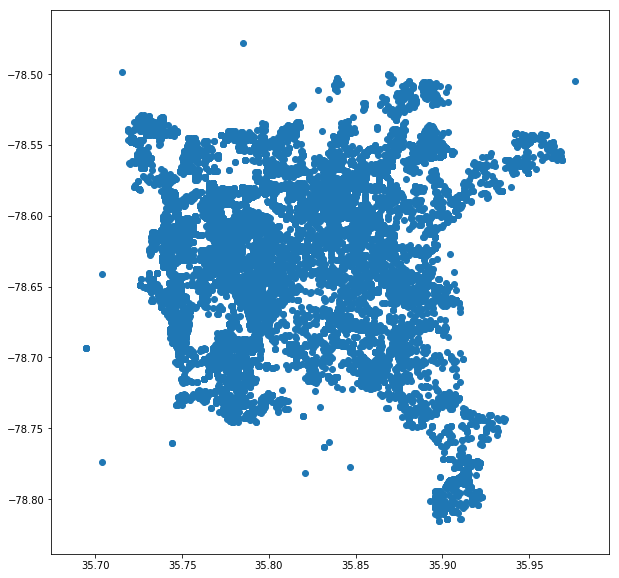

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(crime_data_recent.latitude, crime_data_recent.longitude)
plt.show()

From this, it seems that anywhere from 5 to 10 clusters may be appropriate. To be more accurate I will use the 'elbow' method.

In [14]:
crime_data_recent_clustering = crime_data_recent[['latitude','longitude']].copy()

In [15]:
crime_data_recent_clustering.head()

,latitude,longitude
0,35.851238,-78.659948
1,35.889033,-78.550110
2,35.845355,-78.536339
3,35.810668,-78.537008
4,35.788441,-78.676882


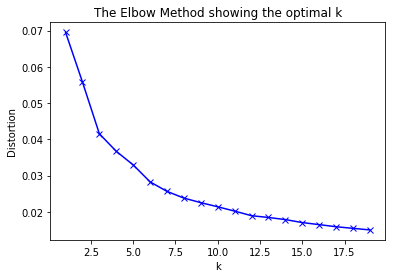

In [16]:
# determine k using elbow method

from sklearn import metrics
from scipy.spatial.distance import cdist

# create new plot and data
plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(crime_data_recent_clustering)
    kmeanModel.fit(crime_data_recent_clustering)
    distortions.append(sum(np.min(cdist(crime_data_recent_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / crime_data_recent_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From this it looks like 6 or 7 clusters would be appropriate. I will use 7, as that looks like the last amount showing rapid reduction in SSE.

### K-Means clustering of crime incidents

In [17]:
# run k-means clustering
kclusters = 7
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(crime_data_recent_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 3, 3, 6, 2, 6, 5, 2, 6, 0], dtype=int32)

In [18]:
cluster_centers = kmeans.cluster_centers_
cluster_centers

array([[ 35.90595936, -78.77353058],
       [ 35.77278341, -78.63345994],
       [ 35.77828942, -78.70087763],
       [ 35.88536256, -78.56308649],
       [ 35.86535493, -78.67933242],
       [ 35.83998549, -78.60089856],
       [ 35.7739416 , -78.56857481]])

In [19]:
center_labels = ('1', '2', '3', '4', '5', '6', '7')
cluster_centers_df = pd.DataFrame({'Center':center_labels, 'Latitude':cluster_centers[:,0], 'Longitude':cluster_centers[:,1]})


In [20]:
cluster_centers_df

,Center,Latitude,Longitude
0,1,35.905959,-78.773531
1,2,35.772783,-78.633460
2,3,35.778289,-78.700878
3,4,35.885363,-78.563086
4,5,35.865355,-78.679332
5,6,35.839985,-78.600899
6,7,35.773942,-78.568575


In [21]:
import geopy.distance

coords_1 = (35.77278341, -78.63345994)
coords_2 = (35.7739416 , -78.56857481)

print(geopy.distance.distance(coords_1, coords_2).km /2)

2.9341915013566173


### Plotting the crime clusters

In [22]:
map_raleigh = folium.Map(location=[35.7721, -78.63861], zoom_start=11)

In [23]:
#add markers to map
for lat, lng, ctr in zip(cluster_centers_df['Latitude'], cluster_centers_df['Longitude'], cluster_centers_df['Center']):
    label = '{}, {}, {}'.format(ctr, lat, lng)
    label = folium.Popup(label, parse_html=True)                 
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_raleigh)

map_raleigh


## Find Top Venues Near Crime Clusters

#### Define Foursquare credentials

In [24]:
CLIENT_ID = 'NCD2O5R3DRHC5WTO0QFQAWBQUCW3ZKPKVQOBBPYIUXNLWPGJ' # your Foursquare ID
CLIENT_SECRET = 'H4HQB4POHT1M4ZNKQOXRTPVTVYEFNMFDBWOLGZNW42TPKUD2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: NCD2O5R3DRHC5WTO0QFQAWBQUCW3ZKPKVQOBBPYIUXNLWPGJ
CLIENT_SECRET:H4HQB4POHT1M4ZNKQOXRTPVTVYEFNMFDBWOLGZNW42TPKUD2


#### Get venues nearby crime centers, using Foursquare

In [25]:
from pandas.io.json import json_normalize
import requests

In [26]:
LIMIT = 300

def getNearbyVenues(names, latitudes, longitudes, radius=3000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Crime Center', 
                  'Crime Center Latitude', 
                  'Crime Center Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
center_venues = getNearbyVenues(names=cluster_centers_df['Center'],
                                   latitudes=cluster_centers_df['Latitude'],
                                   longitudes=cluster_centers_df['Longitude']
                                  )

1
2
3
4
5
6
7


In [28]:
center_venues.head()

,Crime Center,Crime Center Latitude,Crime Center Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,35.905959,-78.773531,Embassy Suites Raleigh - Durham Airport/Brier ...,35.907173,-78.776611,Hotel
1,1,35.905959,-78.773531,Triangle Shooting Academy,35.908973,-78.768521,Gun Range
2,1,35.905959,-78.773531,Blo Salon,35.905660,-78.783830,Salon / Barbershop
3,1,35.905959,-78.773531,Lonerider Brewing Company,35.903490,-78.762819,Brewery
4,1,35.905959,-78.773531,Total Wine & More,35.906998,-78.783281,Liquor Store


In [29]:
center_venues.shape

(664, 7)

In [30]:
center_venues.groupby('Crime Center').count()

,Crime Center Latitude,Crime Center Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Crime Center,,,,,,
1,100,100,100,100,100,100
2,100,100,100,100,100,100
3,100,100,100,100,100,100
4,100,100,100,100,100,100
5,100,100,100,100,100,100
6,100,100,100,100,100,100
7,64,64,64,64,64,64


Venue responses limited by by free Foursquare account

Unique venue categories

In [31]:
print('There are {} uniques categories.'.format(len(center_venues['Venue Category'].unique())))

There are 183 uniques categories.


### Analyze each Crime Center

In [32]:
# one hot encoding
center_onehot = pd.get_dummies(center_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
center_onehot['Crime Center'] = center_venues['Crime Center'] 

In [33]:
center_onehot.shape

(664, 184)

In [34]:
center_grouped = center_onehot.groupby('Crime Center').mean().reset_index()
center_grouped

,Crime Center,Accessories Store,Adult Boutique,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,1,0.00,0.00,0.01,0.010000,0.01,0.00,0.00,0.01,0.010000,...,0.00,0.000000,0.020000,0.01,0.01,0.01,0.00,0.020000,0.00,0.01
1,2,0.00,0.00,0.00,0.040000,0.00,0.01,0.01,0.00,0.040000,...,0.02,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.01
2,3,0.00,0.00,0.00,0.010000,0.00,0.00,0.00,0.00,0.010000,...,0.00,0.000000,0.010000,0.00,0.00,0.00,0.01,0.000000,0.00,0.00
3,4,0.01,0.00,0.00,0.000000,0.00,0.00,0.00,0.01,0.010000,...,0.00,0.010000,0.010000,0.01,0.00,0.01,0.00,0.000000,0.04,0.00
4,5,0.00,0.00,0.00,0.040000,0.00,0.00,0.00,0.00,0.010000,...,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.02,0.00
5,6,0.00,0.01,0.00,0.030000,0.00,0.00,0.00,0.02,0.010000,...,0.00,0.000000,0.000000,0.01,0.00,0.01,0.00,0.020000,0.00,0.00
6,7,0.00,0.00,0.00,0.015625,0.00,0.00,0.00,0.00,0.015625,...,0.00,0.015625,0.046875,0.00,0.00,0.00,0.00,0.015625,0.00,0.00


#### Print each center with top 15 venues

In [35]:
num_top_venues = 15

for cen in center_grouped['Crime Center']:
    print("----"+cen+"----")
    temp = center_grouped[center_grouped['Crime Center'] == cen].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1----
                  venue  freq
0                   Spa  0.05
1           Pizza Place  0.04
2                 Hotel  0.03
3        Sandwich Place  0.03
4    Mexican Restaurant  0.03
5           Coffee Shop  0.03
6     Mobile Phone Shop  0.02
7        Clothing Store  0.02
8          Cocktail Bar  0.02
9     Electronics Store  0.02
10  Japanese Restaurant  0.02
11              Brewery  0.02
12       Breakfast Spot  0.02
13            Pet Store  0.02
14    Indian Restaurant  0.02


----2----
                              venue  freq
0                Italian Restaurant  0.05
1                      Cocktail Bar  0.05
2                  Asian Restaurant  0.04
3                       Coffee Shop  0.04
4               American Restaurant  0.04
5                           Brewery  0.04
6                       Music Venue  0.04
7                               Bar  0.03
8                Mexican Restaurant  0.03
9             Performing Arts Venue  0.02
10                            Plaza 